<a href="https://colab.research.google.com/github/igquinteroch/deep-learning-coursework/blob/main/A1a_DL_TC5033_A01794419.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks


#### Activity 1a: Implementing a Multilayer Fully Connected Network using Numpy
#### Non-graded activity (0 points)

- Objective

  The primary objective of this activity is to deepen your understanding of Fully Connected Networks by implementing a multilayer network using only Numpy. You  are  given  the follosing starter code that solves the MNIST dataset problem. Your task is to read, understand, and then apply this knowledge to solve classification problems on other datasets such as the Kaggle ASL dataset (Starter code will be provided separately for that activity).

- Instructions

    Read and Understand the following Code: The provided starter code outlines the architecture of a Fully Connected Network designed to classify MNIST images. Go through the code to understand how each function and class is used to implement the network.

    Understand the Math: Make sure you understand the math operations implemented in the code, especially during the forward and backward passes. This will involve matrix multiplications, activation functions, loss computations, and backpropagation.
    
- Experiment
    You are encouraged to play with the code, change any hyperparameters and train the model, you should be able to achieve over 95% accuracy on the test set without problems.


### Import the libraries and set the stage

* `numpy`: Performs mathematical operations on large arrays or matrices.
* `matplotlib.pyplot`: Used for plotting data.
* `%matplotlib inline`: It displays the figures inline in the notebook.
* `os`: Allows interaction with the OS - e.g., directory navigation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("/content/drive/MyDrive/TC5033.10")

Mounted at /content/drive


### Import Images

In [2]:
from get_images import get_images

# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)


x_train = x_train_num[:50000].reshape(50000, -1).astype(float) # First 50k data and reshape it
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)

In [3]:
x_train.mean(), x_train.std(), x_train.min()

(33.39512885204082, 78.6661972212754, 0.0)

In [4]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

It's necessary to normalize the validation and test data with the statistical data from training.

In [5]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [6]:
x_train.mean(), x_train.std()

(-9.646705203355238e-18, 0.9999999999999997)

### Plot samples

The following section helps to visualize and inspect random samples from the dataset.

In [7]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

The image represents a/an: 5


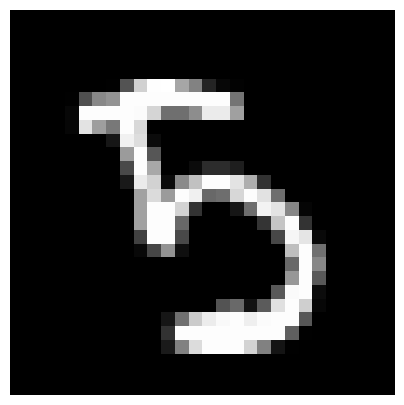

In [8]:
rnd_idx = np.random.randint(len(y_test))
print(f'The image represents a/an: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Equations provided for our model

$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$


$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$

$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$

$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Helper functions

#### Create mini batches

The following section divides the section into smaller subsets called **mini-batches.**

They make the training process faster and more effective at learning from the dataset.

In [11]:
def create_minibatches(mb_size, x, y, shuffle=True):
    '''
    Creates minibatches from the dataset.

    Parameters:
        mb_size (int): The size of each minibatch.
        x (np.ndarray): Input data of shape (num_samples, num_features).
        y (np.ndarray): Labels of shape (num_samples) from the input data.
        shuffle (bool): Whether to shuffle the data before creating minibatches. Default is True.
    '''
    assert x.shape[0] == y.shape[0], 'Error in number of samples'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Linear, ReLU, and Sequential Classes

In [12]:
# Generate attributes to the parameters using the below class
"""
(np.ndarray): This indicates that the new class ´np_tensor´ inherits from the ´np.ndarray´ class.
´np.ndarray´ is the core class in the NumPy library representing multi-dimensional arrays.
By inheriting from ´np.darray´, ´np_tensor´ gets all the functionality of NumPy arrays.
"""

class np_tensor(np.ndarray): pass

In [13]:
a = np.array([0, 0])
b = a.view(np_tensor)

In [15]:
type(a), type(b)

(numpy.ndarray, __main__.np_tensor)

In [16]:
a == b

np_tensor([ True,  True])

###  Linear Class

$$z^1 = W^1 X + b^1$$



In [17]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters using Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)

    # __call__: It is called automatically when we call the name of the class instance and pass the parameters
    def __call__(self, X):
        Z = self.W @ X + self.b # @ = dot product
        return Z

    def backward(self, X, Z): # X = input (output from the previous layer), Z = output
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)


### ReLU Class

In the following section, we apply the ReLU activation function to the input data (input data coming from the activation function of the previous layer).

$$a^1 = ReLU(z^1) $$

In [19]:
class ReLU():
    def __call__(self, Z): # Z: input
        return np.maximum(0, Z)
    def backward(self, Z, A): # A: output
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Sequential Class

In [20]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - list that contains Linear type objects, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))

### Cost Function

In [22]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()

    # Cost
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size

    # Calculate gradients
    probs[y.squeeze(), np.arange(batch_size)] -= 1
    x.grad = probs.copy()

    return preds, cost

### Training loop

In [34]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'Cost: {cost:.4f} | Accuracy: {accuracy(x_val, y_val, mb_size):.2f}')

In [35]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

In [36]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 10)])
mb_size = 512
learning_rate = 1e-4
epochs = 20

In [37]:
train(model, epochs, mb_size, learning_rate)

Cost: 0.3565 | Accuracy: 0.92
Cost: 0.2288 | Accuracy: 0.94
Cost: 0.1447 | Accuracy: 0.95
Cost: 0.1643 | Accuracy: 0.95
Cost: 0.1435 | Accuracy: 0.96
Cost: 0.1268 | Accuracy: 0.96
Cost: 0.1309 | Accuracy: 0.96
Cost: 0.1130 | Accuracy: 0.96
Cost: 0.0942 | Accuracy: 0.96
Cost: 0.1025 | Accuracy: 0.97
Cost: 0.0781 | Accuracy: 0.97
Cost: 0.0678 | Accuracy: 0.97
Cost: 0.1089 | Accuracy: 0.97
Cost: 0.0399 | Accuracy: 0.97
Cost: 0.1270 | Accuracy: 0.97
Cost: 0.0611 | Accuracy: 0.97
Cost: 0.0849 | Accuracy: 0.97
Cost: 0.0523 | Accuracy: 0.97
Cost: 0.0512 | Accuracy: 0.97
Cost: 0.0543 | Accuracy: 0.97


In [38]:
print(accuracy(x_test, y_test, mb_size))

0.9712


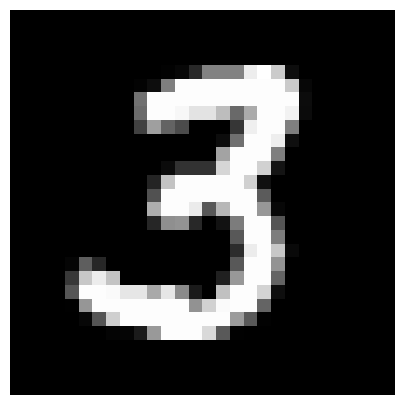

The predicted value is: 3 | The real value is: 3


In [50]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'The predicted value is: {pred} | The real value is: {y_test[idx][0]}')